# Dressed Spin States

## Imports and Definitions

In [1]:
import json

import numpy as np
import scipy as sp
import sympy as sym
import matplotlib.pyplot as plt

from labellines import labelLines
from glob import glob
from scipy.optimize import curve_fit

from helperFunctions import *

In [2]:
# plot settings, increase font sizes
plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.labelspacing'] = 0.2

## Symbolic Hamiltonian Matrix

In [3]:
sym.init_printing(use_unicode=True)

# number of photons
n = sym.Symbol('n')

# dressing parameters
x = sym.Symbol('x')
y = sym.Symbol('y')

# dressing field frequency
wd = sym.Symbol('w_d')

# reduced Plank constant
hbar = sym.Symbol('hbar')

In [4]:
N = 10

h0_pos = n+np.arange((N-2)/4, -N/4, -1, dtype=int)+y/2
h0_neg = n+np.arange((N-2)/4, -N/4, -1, dtype=int)-y/2

diags = np.vstack((h0_pos,h0_neg)).flatten('F')

H0 = sym.zeros(N)
for i in range(N):
    H0[i,i] = sym.sympify(diags[i])
H0 = sym.ImmutableDenseMatrix(H0)


off_1 = np.ones(N-1)/4
off_1[0::2] = 0

off_3 = np.ones(N-3)/4
off_3[1::2] = 0

Vx = (sp.sparse.diags(off_1, offsets=1).toarray()
      + sp.sparse.diags(off_3, offsets=3).toarray() 
      + sp.sparse.diags(off_1, offsets=-1).toarray() 
      + sp.sparse.diags(off_3, offsets=-3).toarray())
Vx = sym.ImmutableDenseMatrix(x * sym.sympify(Vx))

H = H0 + Vx
H

⎡    y                                                                                                 ⎤
⎢n + ─ + 2      0          0       0.25⋅x      0       0         0          0          0          0    ⎥
⎢    2                                                                                                 ⎥
⎢                                                                                                      ⎥
⎢               y                                                                                      ⎥
⎢    0      n - ─ + 2   0.25⋅x        0        0       0         0          0          0          0    ⎥
⎢               2                                                                                      ⎥
⎢                                                                                                      ⎥
⎢                          y                                                                           ⎥
⎢    0       0.25⋅x    n + ─ + 1      0        0     0.

## Energy Level Diagram Calculation

In [5]:
f0 = 1000
fd = 1250

# define the parameter space
N = 46
X = np.linspace(0, 4, 1001)

y = f0/fd

print('dressing parameter x: {} - {}'.format(X.min(),X.max()))
print('dressing parameter y: {}'.format(y))

dressing parameter x: 0.0 - 4.0
dressing parameter y: 0.8


In [6]:
# calculate the energy levels
EV_y0 = calcEnergyLevels_X(X, y, N)

# select the n=0 levels to search for crossings
EV1 = EV_y0[:,N//2]
EV2 = EV_y0[:,N//2-1]

# find the crossing indices and manually ad the begining and the end
dE = EV1 - EV2
idx_peaks = sp.signal.find_peaks(-dE)[0]
idx_peaks = np.concatenate(([0],idx_peaks+1,[None]))

# switch energy levels at crossing indices
EV1_t = np.zeros(len(X))
EV2_t = np.zeros(len(X))
for n in np.arange(0, N, 2):
    EV1 = EV_y0[:,n]
    EV2 = EV_y0[:,n+1]
    for i in range(len(idx_peaks)-1):
        if i%2==0:
            EV1_t[idx_peaks[i]:idx_peaks[i+1]] = EV1[idx_peaks[i]:idx_peaks[i+1]]
            EV2_t[idx_peaks[i]:idx_peaks[i+1]] = EV2[idx_peaks[i]:idx_peaks[i+1]]
        else:
            EV1_t[idx_peaks[i]:idx_peaks[i+1]] = EV2[idx_peaks[i]:idx_peaks[i+1]]
            EV2_t[idx_peaks[i]:idx_peaks[i+1]] = EV1[idx_peaks[i]:idx_peaks[i+1]]
    EV_y0[:,n] = EV1_t
    EV_y0[:,n+1] = EV2_t

# flip sign according to |+> to |-> flip
# this gives a positive resonance frequency for the main resonance at x=0
sign = np.ones(N//2) if fd<f0 else -np.ones(N//2)
sign[0::2] *= -1

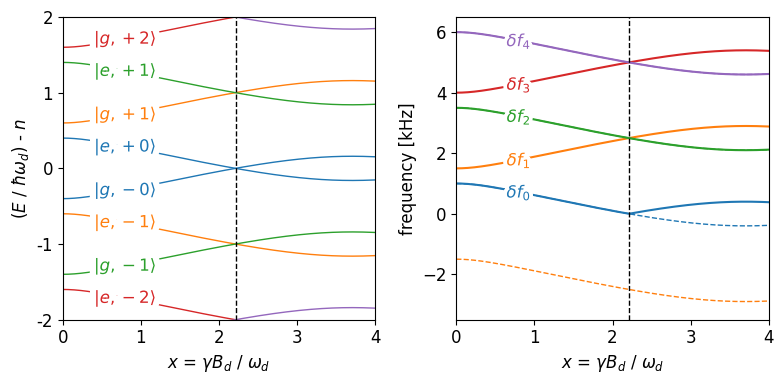

In [7]:
fig, ax = plt.subplots(1,2,figsize=(8,4))

# calculate energy difference and plot energy levels
dE = np.zeros((N//2, len(X)))
for i in np.arange(N//2):
    state1 = 'g' if i%2==1 else 'e'
    state2 = 'e' if i%2==1 else 'g'
    dE[i] = EV_y0[:,N//2+i] - EV_y0[:,N//2-i-1]
    ax[0].plot(X, EV_y0[:,N//2+i], 'C{}-'.format(i%9), lw=1, label=r'$\left.|{},+{}\right>$'.format(state1,(i+1)//2))
    ax[0].plot(X, EV_y0[:,N//2-i-1], 'C{}-'.format(i%9), lw=1, label=r'$\left.|{},-{}\right\rangle$'.format(state2,(i+1)//2))
labelLines(ax[0].get_lines(), align=False, outline_width=9, zorder=9, xvals=(0.8,0.8))
ax[0].set(xlabel='$x$ = $\gamma B_d$ / $\omega_d$', xlim=(X.min(), X.max()), 
          ylabel='$(E$ / $\hbar \omega_d)$ - $n$', ylim=(-2,2))
xticks = np.arange(-2,2+0.1,1, dtype=int)
ax[0].set_yticks(xticks)
ax[0].set_yticklabels(xticks)

# plot energy levels
Nlevels = 5
for i in np.arange(Nlevels):
    ax[1].plot(X, fd*dE[i]*sign[i]/1e3, 'C{}--'.format(i), lw=1)
    ax[1].plot(X, abs(fd*dE[i]*sign[i])/1e3, 'C{}-'.format(i), label=r'$\delta f_{}$'.format(i))
    labelLines(ax[1].get_lines(), align=False, zorder=9, xvals=(0.8,0.8))

# plot the level crossing
ax[0].axvline(X[idx_peaks[1]], c='k', ls='--', lw=1)
ax[1].axvline(X[idx_peaks[1]], c='k', ls='--', lw=1)

ax[1].set(xlabel='$x$ = $\gamma B_d$ / $\omega_d$', xlim=(X.min(), X.max()), 
          ylabel='frequency [kHz]', ylim=(-3.5,6.5))

fig.set(dpi=100)
fig.tight_layout()

plt.show()

## Measurements

### Water Flow Velocity

In [8]:
files = glob('data/*/*.npz')
Flow = np.zeros(len(files))

for i,file in enumerate(files):
    Flow[i] = np.load(file)['flow']

print('flow: ({:.2f} +/- {:.2f}) m/s'.format(Flow.mean(), Flow.std()))

flow: (1.21 +/- 0.02) m/s


### Spectrum

In [9]:
# dressing field frequency in [Hz]
f0 = 1000
fd = 350

path = 'data/20230511_dressedStates_y0415mA_pump2500mV_fd0350Hz/'

# load the dressing field amplitudes in [mVpp]
with open('processed/f01000Hz_fd0350Hz_dressAmp.json', 'r') as fp: dressAmp = json.load(fp)

# load the resonance frequencies in [Hz]
with open('processed/f01000Hz_fd0350Hz_resFrq.json', 'r') as fp: resFrq = json.load(fp)
f0 = resFrq[0][0]

# find the x-scale (dressing field amplitude) by minimization
tol = 0.01
res = findScale(dressAmp, resFrq, f0, fd, s0=500, Nlevels=9, tol=tol)
if res.success:
    scale = res.x[0], np.sqrt(np.diag(res.hess_inv.todense())*tol*res.fun)[0]
    print('scale:\t\t\t{:.1f} ± {:.1f}'.format(*scale))
else:
    print('minimization not successful')

# field conversion factor in [uT/Vpp]
conv = 2*np.pi*fd/gamma_p/scale[0] * 1e9
print('field conversion:\t{:.2f} uT/Vpp'.format(conv))

X = np.linspace(0, dressAmp[-1], 1001) / scale[0]
y = f0 / fd

scale:			458.4 ± 0.2
field conversion:	17.93 uT/Vpp


3.7082582536812803 30.483026096645386
reduced chi-squared: 0.25

f0, A, s
28.0 -0.204 26.5 +/- 5.4 0.020 5.5
667.4 -0.221 26.2 +/- 2.6 0.017 2.7
1368.6 -1.222 27.8 +/- 0.3 0.013 0.4
2058.0 -0.049 20.2 +/- 10.9 0.023 11.3

o
0.914 +/- 0.002


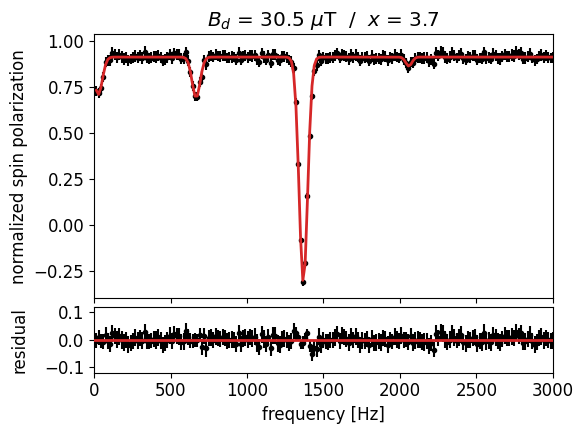

In [10]:
i = 17
F0 = np.array([20,680,1380,2080])
popt = np.array([F0[0],-0.2,26,F0[1],-0.2,26,F0[2],-1.5,26,F0[3],-0.05,26,0.9])

# load data
data = np.load(path+'dressedStates_{:02d}.npz'.format(i))
F_SF = data['F_SF']
Amp = data['Amp']
vd = data['Vd'][i]

# dressing field amplitude in [uT]
Bd = conv*vd/1e3

# dressing parameter
x = (gamma_p/2/np.pi) * Bd / fd / 1e6
print(x, Bd)

popt, pcov = curve_fit(fourGaussFct, F_SF, Amp[0], sigma=Amp[1], absolute_sigma=True, p0=popt)
perr = np.sqrt(np.diag(pcov))

chi2 = np.sum((Amp[0]-fourGaussFct(F_SF, *popt))**2 / Amp[1]**2)
chi2_r = chi2 / (len(Amp[0]) - len(popt))

print('reduced chi-squared: {:.2f}\n'.format(chi2_r))

# print optimized parameters
print('f0, A, s')
for i in range(len(popt)//3):
    print('{:.1f} {:.3f} {:.1f} +/- {:.1f} {:.3f} {:.1f}'.format(*popt[i*3:(i+1)*3], *perr[i*3:(i+1)*3]))
print('\no')
print('{:.3f} +/- {:.3f}'.format(popt[-1], perr[-1]))

# plot the data with the spectrum and the residuals
fig, ax = plt.subplots(2,1,sharex=True,figsize=(6,4.5),gridspec_kw={'height_ratios':[4,1]})
ax[0].errorbar(F_SF, Amp[0], Amp[1], fmt='k.', zorder=1, label='data')
ax[0].plot(F_SF, fourGaussFct(F_SF, *popt), 'C3-', lw=2, label='least-squares fit')
ax[0].set(title='$B_d$ = {:.1f} $\mu$T  /  $x$ = {:.1f}'.format(Bd, x), ylabel='normalized spin polarization', xlim=(0,F_SF.max()))
ax[1].errorbar(F_SF, (Amp[0]-fourGaussFct(F_SF, *popt)), Amp[1], fmt='k.')
ax[1].axhline(0, c='C3', ls='-', lw=2, zorder=9)
ax[1].set(xlabel='frequency [Hz]',  ylabel='residual', ylim=(-0.12,0.12))
fig.set(dpi=100)
fig.tight_layout()
fig.subplots_adjust(hspace=0.05) # remove horizontal space between axes
fig.align_ylabels(ax) # align y-labels
plt.show()

pull-std:	0.484
res-std:	0.013
err-mean:	0.029


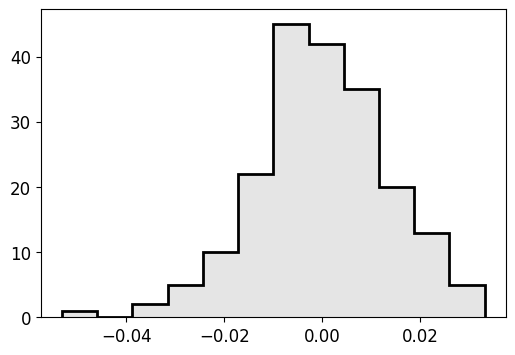

In [11]:
print(f'pull-std:\t{((Amp[0]-fourGaussFct(F_SF, *popt))/Amp[1]).std():.3f}')
print(f'res-std:\t{(Amp[0]-fourGaussFct(F_SF, *popt)).std():.3f}')
print(f'err-mean:\t{ Amp[1].mean():.3f}')

fig, ax = plt.subplots()
ax.hist((Amp[0]-fourGaussFct(F_SF, *popt)), 12, color='k', lw=2, alpha=0.1)
ax.hist((Amp[0]-fourGaussFct(F_SF, *popt)), 12, color='k', histtype='step', lw=2)
plt.show()

### Energy Levels

In [12]:
# calculate the energy levels
Ncalc = 46
Nlevels = 9
EV_y0 = calcEnergyLevels_X(X, y, Ncalc)    
EV1 = EV_y0[:,Ncalc//2]
EV2 = EV_y0[:,Ncalc//2-1]
dE = EV1 - EV2
idx_peaks = sp.signal.find_peaks(-dE)[0]
idx_peaks = np.concatenate(([0],idx_peaks+1,[None]))
EV1_t = np.zeros(len(X))
EV2_t = np.zeros(len(X))
for n in np.arange(0, Ncalc, 2):
    EV1 = EV_y0[:,n]
    EV2 = EV_y0[:,n+1]
    for i in range(len(idx_peaks)-1):
        if i%2==0:
            EV1_t[idx_peaks[i]:idx_peaks[i+1]] = EV1[idx_peaks[i]:idx_peaks[i+1]]
            EV2_t[idx_peaks[i]:idx_peaks[i+1]] = EV2[idx_peaks[i]:idx_peaks[i+1]]
        else:
            EV1_t[idx_peaks[i]:idx_peaks[i+1]] = EV2[idx_peaks[i]:idx_peaks[i+1]]
            EV2_t[idx_peaks[i]:idx_peaks[i+1]] = EV1[idx_peaks[i]:idx_peaks[i+1]]
    EV_y0[:,n] = EV1_t
    EV_y0[:,n+1] = EV2_t
dE = np.zeros((Ncalc//2, len(X)))
for i in np.arange(Ncalc//2):
    dE[i] = EV_y0[:,Ncalc//2+i] -  EV_y0[:,Ncalc//2-i-1]
sign = np.ones(Ncalc//2) if fd<f0 else -np.ones(Ncalc//2)
sign[0::2] *= -1

x=3.708, Bd=30.483 uT
x=5.453, Bd=44.828 uT


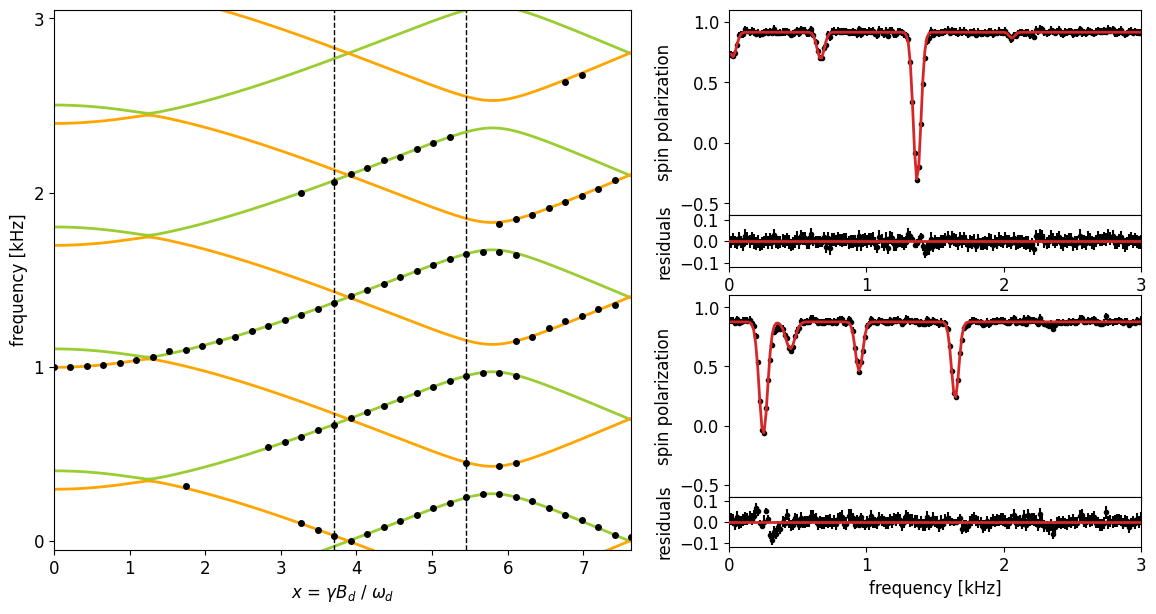

In [13]:
fig = plt.figure(figsize=(12, 6))

subfigs = fig.subfigures(1, 2, width_ratios=[1.4, 1])
subfigsnest = subfigs[1].subfigures(2, 1, height_ratios=[1, 1.1])

# create first subfigure with energy level diagram
ax0 = subfigs[0].subplots()
subfigs[0].subplots_adjust(top=1, bottom=0.1, right=0.95)

# plot the fitted resonances
for i,amp in enumerate(dressAmp):
    for j,frq in enumerate(resFrq[i]):
        ax0.errorbar(amp/scale[0], frq, fmt='k.', ms=8)

# plot the calculated energy levels
for i in np.arange(Ncalc//2):
    #ax0.plot(X, abs(fd*dE[i]*sign[i])-2*fd, zorder=1, c='k', lw=2)
    ax0.plot(X, abs(fd*dE[i]*sign[i])-2*fd, zorder=1, c='{}'.format('orange' if i%2==0 else 'yellowgreen'), lw=2)

# plot the vertical lines that indicate the locations of the spectra
ax0.axvline(dressAmp[17]/scale[0], c='k', ls='--', lw=1)
ax0.axvline(dressAmp[25]/scale[0], c='k', ls='--', lw=1)

# configure subfigure
ax0.set(xlabel='$x$ = $\gamma B_d$ / $\omega_d$', xlim=(X[0], X[-1]), 
        ylabel='frequency [kHz]', ylim=(-50,3050))
yticks = np.arange(0,3+0.1,1, dtype=int)
ax0.set_yticks(1e3*yticks)
ax0.set_yticklabels(yticks)

# create the subfigures for the spectra
ax10 = subfigsnest[0].subplots(2, 1, sharex=True, height_ratios=[4,1])
subfigsnest[0].subplots_adjust(hspace=0.0)
ax11 = subfigsnest[1].subplots(2, 1, sharex=True, height_ratios=[4,1])
subfigsnest[1].subplots_adjust(hspace=0.0)


# plot the first spectrum
i = 17
F0 = np.array([20,680,1380,2080])
popt = np.array([F0[0],-0.2,26,F0[1],-0.2,26,F0[2],-1.5,26,F0[3],-0.05,26,0.9])

# load data
data = np.load(path+'dressedStates_{:02d}.npz'.format(i))
F_SF = data['F_SF']
Amp = data['Amp']
vd = data['Vd'][i]

# dressing field amplitude in [uT]
Bd = conv*vd/1e3

# dressing parameter
x = (gamma_p/2/np.pi) * Bd / fd / 1e6
print(f'x={x:.3f}, Bd={Bd:.3f} uT')

popt, pcov = curve_fit(fourGaussFct, F_SF, Amp[0], sigma=Amp[1], absolute_sigma=True, p0=popt)
perr = np.sqrt(np.diag(pcov))

ax10[0].errorbar(F_SF, Amp[0], Amp[1], fmt='k.', zorder=1, label='data')
ax10[0].plot(F_SF, fourGaussFct(F_SF, *popt), 'C3-', lw=2, label='least-squares fit')
ax10[0].set(ylabel='spin polarization', xlim=(0,F_SF.max()), ylim=(-0.6, 1.1))
ax10[1].errorbar(F_SF, (Amp[0]-fourGaussFct(F_SF, *popt)), Amp[1], fmt='k.')
ax10[1].axhline(0, c='C3', ls='-', lw=2, zorder=9)
ax10[1].set(ylabel='residuals', ylim=(-0.12,0.12))
xticks = np.arange(0,3+0.1,1, dtype=int)
ax10[1].set_xticks(1e3*xticks)
ax10[1].set_xticklabels(xticks)

# plot the second spectrum
i = 25
F0 = np.array([250,450,1000,1700])
popt = np.array([F0[0],-1,26,F0[1],-0.2,26,F0[2],-1.5,26,F0[3],-0.2,26,0.9])

# load data
data = np.load(path+'dressedStates_{:02d}.npz'.format(i))
F_SF = data['F_SF']
Amp = data['Amp']
vd = data['Vd'][i]

# dressing field amplitude in [uT]
Bd = conv*vd/1e3

# dressing parameter
x = (gamma_p/2/np.pi) * Bd / fd / 1e6
print(f'x={x:.3f}, Bd={Bd:.3f} uT')

popt, pcov = curve_fit(fourGaussFct, F_SF, Amp[0], sigma=Amp[1], absolute_sigma=True, p0=popt)
perr = np.sqrt(np.diag(pcov))

ax11[0].errorbar(F_SF, Amp[0], Amp[1], fmt='k.', zorder=1, label='data')
ax11[0].plot(F_SF, fourGaussFct(F_SF, *popt), 'C3-', lw=2, label='least-squares fit')
ax11[0].set(ylabel='spin polarization', xlim=(0,F_SF.max()), ylim=(-0.6, 1.1))
ax11[1].errorbar(F_SF, (Amp[0]-fourGaussFct(F_SF, *popt)), Amp[1], fmt='k.')
ax11[1].axhline(0, c='C3', ls='-', lw=2, zorder=9)
ax11[1].set(xlabel='frequency [kHz]',  ylabel='residuals', ylim=(-0.12,0.12))
xticks = np.arange(0,3+0.1,1, dtype=int)
ax11[1].set_xticks(1e3*xticks)
ax11[1].set_xticklabels(xticks)

# configure the figure
subfigsnest[0].align_ylabels(ax10) # align y-labels
subfigsnest[1].align_ylabels(ax11) # align y-labels
subfigsnest[1].subplots_adjust(bottom=0.2)

fig.set(dpi=100)

plt.show()

### Density Plot with Energy Levels

In [14]:
# dressing field frequency in [Hz]
fd = 350

# load the dressing field amplitudes in [mVpp]
with open('processed/f01000Hz_fd0350Hz_dressAmp_2.json', 'r') as fp: dressAmp = json.load(fp)

# load the resonance frequencies in [Hz]
with open('processed/f01000Hz_fd0350Hz_resFrq_2.json', 'r') as fp: resFrq = json.load(fp)
with open('processed/f01000Hz_fd0350Hz_resErr_2.json', 'r') as fp: resErr = json.load(fp)
f0 = resFrq[0][0]

# find the x-scale (dressing field amplitude) by minimization
tol = 0.01
res = findScale(dressAmp, resFrq, f0, fd, s0=500, Nlevels=9, tol=tol)
if res.success:
    scale = res.x[0], np.sqrt(np.diag(res.hess_inv.todense())*tol*res.fun)[0]
    print('scale = {:.2f} ± {:.2f}'.format(*scale))
else:
    print('minimization not successful')

scale = 458.52 ± 0.22


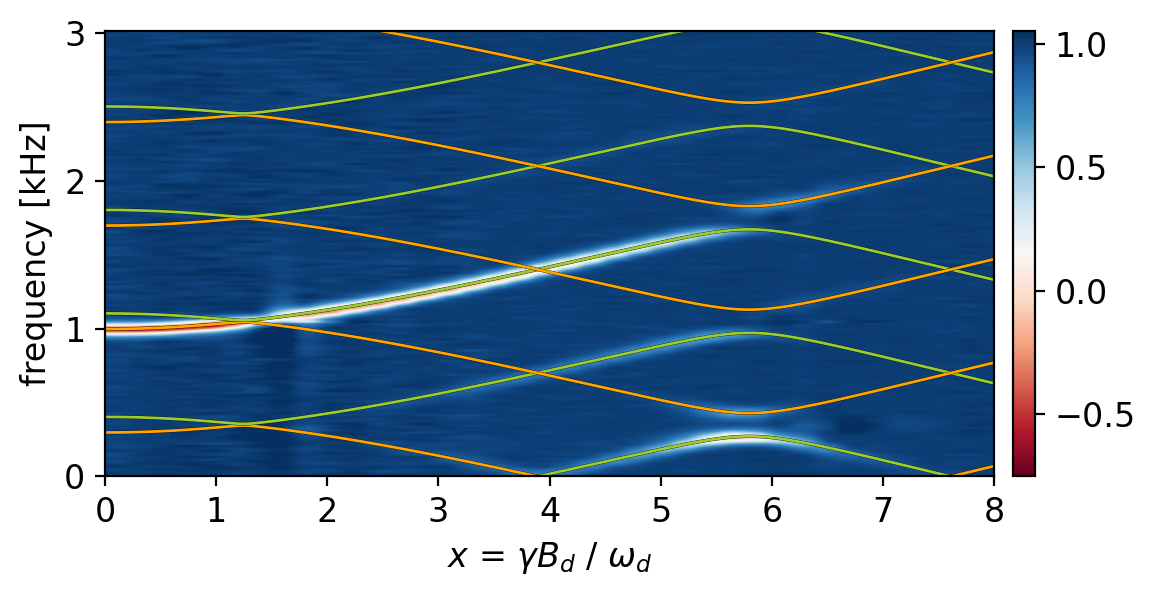

In [15]:
path = 'data/20230511_dressedStates_y0415mA_pump2500mV_fd0350Hz/'
files = sorted(glob(path+'dressedStates_*.npz'))


# dressing parameter x
X = np.linspace(0, dressAmp[-1], 1001) / scale[0]

# dressing parameter y
y = f0 / fd

N = len(files)
M = len(np.load(files[0])['F_SF'])
im_ratio = M/N

signal = np.zeros((N,M))

for n,file in enumerate(files):
    sig = np.load(file)['Amp'][0]
    sigMean = sig[180:].mean()
    signal[n] = sig-sigMean+1

signal = np.flip(signal.T, axis=0)


fig, ax = plt.subplots(figsize=(6,10))
cs = ax.imshow(signal, aspect=0.00133, extent=(X.min(),X.max(),0,3000), vmin=-0.75, vmax=1.05, cmap='RdBu', interpolation='gaussian') #RdBu, inferno


fig.colorbar(cs, fraction=0.0049*im_ratio, pad=0.02)


# calculate the energy levels
Ncalc = 46
Nlevels = 9
EV_y0 = calcEnergyLevels_X(X, y, Ncalc)    
EV1 = EV_y0[:,Ncalc//2]
EV2 = EV_y0[:,Ncalc//2-1]
dE = EV1 - EV2
idx_peaks = sp.signal.find_peaks(-dE)[0]
idx_peaks = np.concatenate(([0],idx_peaks+1,[None]))
EV1_t = np.zeros(len(X))
EV2_t = np.zeros(len(X))
for n in np.arange(0, Ncalc, 2):
    EV1 = EV_y0[:,n]
    EV2 = EV_y0[:,n+1]
    for i in range(len(idx_peaks)-1):
        if i%2==0:
            EV1_t[idx_peaks[i]:idx_peaks[i+1]] = EV1[idx_peaks[i]:idx_peaks[i+1]]
            EV2_t[idx_peaks[i]:idx_peaks[i+1]] = EV2[idx_peaks[i]:idx_peaks[i+1]]
        else:
            EV1_t[idx_peaks[i]:idx_peaks[i+1]] = EV2[idx_peaks[i]:idx_peaks[i+1]]
            EV2_t[idx_peaks[i]:idx_peaks[i+1]] = EV1[idx_peaks[i]:idx_peaks[i+1]]
    EV_y0[:,n] = EV1_t
    EV_y0[:,n+1] = EV2_t
dE = np.zeros((Ncalc//2, len(X)))
for i in np.arange(Ncalc//2):
    dE[i] = EV_y0[:,Ncalc//2+i] -  EV_y0[:,Ncalc//2-i-1]
sign = np.ones(Ncalc//2) if fd<f0 else -np.ones(Ncalc//2)
sign[0::2] *= -1

# plot the calculated energy levels
for i in np.arange(Ncalc//2):
    ax.plot(X, abs(fd*dE[i]*sign[i])-2*fd, zorder=1, c='k', lw=1.2)
    if i%2==0:
        ax.plot(X, abs(fd*dE[i]*sign[i])-2*fd, zorder=1, c='orange', lw=1)
    else:
        ax.plot(X, abs(fd*dE[i]*sign[i])-2*fd, zorder=1, c='yellowgreen', lw=1)


ax.set(xlabel='$x$ = $\gamma B_d$ / $\omega_d$', xlim=(0,8),
       ylabel='frequency [kHz]', ylim=(0,3015))

yticks = np.array([0,1000,2000,3000], dtype=int)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks//1000)

fig.set(dpi=200)
#fig.tight_layout()

plt.show()